In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

from emulate import SphericalWell
from emulate import BoundStateHamiltonian
from emulate import BoundStateOperator
from emulate import convert_from_r_to_ho_basis, kinetic_energy_ho_basis, fourier_transform_spherical
from emulate import leggauss_shifted
from emulate import ho_energy, ho_radial_wf
from emulate import setup_rc_params

In [2]:
setup_rc_params()

sns.set_palette('pastel')

# An Emulator Example with a Perturbed Oscillator Potential
Author: Jordan Melendez


I would have liked to make this much nicer and better documented, but I ran out of time. I hope someone can still find value in this example.

Start by setting the parameters.

In [3]:
ell = 0     # Partial wave
n_max = 10  # Oscillator basis size
mass = 1    # mass
b = 1       # Oscillator parameter
# Gaussian quadrature points
r, dr = leggauss_shifted(100, 0, 10)
# Gridded points (for plotting)
r_grid = np.linspace(0, 3, 301)

Create all the operators and wave functions that will be needed later on

In [4]:
osc_wfs = np.stack([ho_radial_wf(r=r_grid, n=i+1, ell=ell, b=b) for i in range(n_max+1)], axis=-1)

# Make Gaussian perturbations to the oscillator
H1_params = [0.5, 2, 4]
H1_r_grid = np.stack([np.exp(-(r_grid/a)**2) for a in H1_params], axis=-1)
H1_r = np.stack([np.exp(-(r/a)**2) for a in H1_params], axis=-1)

# Constant term: expected shape = (N_ho_basis, N_ho_basis)
H0 = np.diag([ho_energy(n, ell, omega=1) for n in range(1, n_max+2)])
# Linear term: expected shape = (N_ho_basis, N_ho_basis, n_parameters)
H1 = np.stack([
    convert_from_r_to_ho_basis(H1_r_i, n_max=n_max, ell=ell, r=r, dr=dr, b=b)
    for H1_r_i in H1_r.T
], axis=-1)

R = convert_from_r_to_ho_basis(r, n_max=n_max, ell=ell, r=r, dr=dr, b=b)

In [5]:
def oscillator_potential(r, mass, omega):
    return 0.5 * mass * (omega * r) ** 2

In [6]:
rng = np.random.default_rng(1)
p_train = rng.uniform(-5, 5, size=(6, H1.shape[-1]))
p_valid = rng.uniform(-5, 5, size=(50, H1.shape[-1]))

This is the emulator object that is doing all the work here!
Check it out in the `emulate` package.
Now `fit` will train the emulator. Later we will use `predict` to get the output energies either using the emulator or the exact solver.

In [7]:
ham = BoundStateHamiltonian('Osc w/Gaussian Perturbation', H0=H0, H1=H1)
ham.fit(p_train)

BoundStateHamiltonian(Osc w/Gaussian Perturbation)

Also create one that doesn't use exact training wave functions as the basis. Instead, use the lowest 6 harmonic oscillator wave functions as the basis. This is like no-core shell model (NCSM), so that is how we will label it here.

In [8]:
ham_ncsm = BoundStateHamiltonian('Osc w/Gaussian Perturbation', H0=H0, H1=H1)
ham_ncsm.fit(p_train)
# Fake the basis wave functions as harmonic oscillator states
# Because we are in the HO basis, these are just vectors with 1's and 0's
ham_ncsm.setup_projections(np.eye(*ham.X.shape))
E_pred_ncsm = np.stack([ham_ncsm.predict(p_i, use_emulator=True) for p_i in p_valid])

Get the energies and the basis wave functions used for "training" the emulator. They are in the HO basis, but multiply by the harmonic oscillator wave function in position space to tranform to position space.

In [9]:
E_pred = np.stack([ham.predict(p_i, use_emulator=True) for p_i in p_valid])
E_full = np.stack([ham.predict(p_i, use_emulator=False) for p_i in p_valid])

wf_train = osc_wfs @ ham.X

Plot the training wave functions in position space

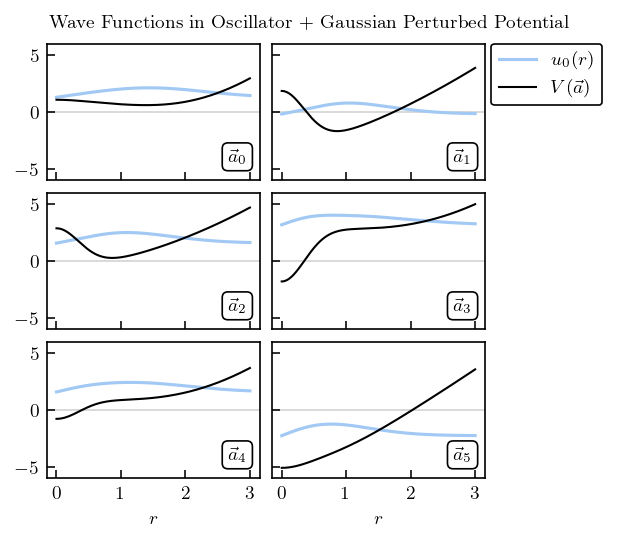

In [10]:
fig, axes = plt.subplots(len(p_train)//2, 2+(len(p_train)%2), figsize=(4, 3.5), sharey=True, sharex=True)

V0 = oscillator_potential(r_grid, mass=mass, omega=1)
for i, p_i in enumerate(p_train):
    ax = axes.ravel()[i]
    ax.plot(r_grid, wf_train[:, i]+ham.E_train[i], label=r'$u_0(r)$')
    ax.axhline(0, 0, 1, c='lightgrey', lw=0.8, zorder=0)
    V = V0 + H1_r_grid @ p_i
    ax.plot(r_grid, V, c='k', lw=1, label=r"$V(\vec{a})$")
    ax.text(
        0.94, 0.11, fr"$\vec{{a}}_{{{i}}}$",
        transform=ax.transAxes, ha='right', va='bottom',
        bbox=dict(facecolor='w', boxstyle='round'),
    )
axes[0, -1].legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
for ax in axes[-1]:
    ax.set_xlabel(r"$r$")
    ax.set_xticks([0, 1, 2, 3])
ax.set_ylim(-6, 6)
fig.suptitle("Wave Functions in Oscillator + Gaussian Perturbed Potential")
fig.savefig("wave_functions_efficient_basis.png")

In [11]:
from emulate.graphs import PRED_KWARGS, BASIS_KWARGS, FULL_KWARGS

Emulate the wave functions at unseen parameter locations. Also predict them exactly and compare

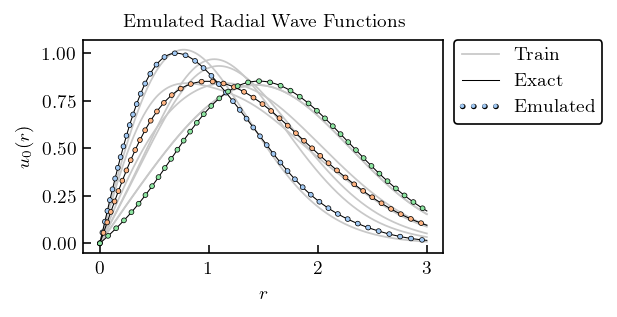

In [12]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(r_grid, wf_train[:, 0], label='Train', **BASIS_KWARGS)
ax.plot(r_grid, wf_train, **BASIS_KWARGS)
for i in range(3):
    if i == 0:
        label_full = 'Exact'
        label_pred = 'Emulated'
    else:
        label_full = label_pred = None
    ax.plot(r_grid, osc_wfs @ ham.exact_wave_function(p_valid[i]), label=label_full, **FULL_KWARGS)
    ax.plot(r_grid, osc_wfs @ ham.emulate_wave_function(p_valid[i]), label=label_pred, **PRED_KWARGS)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$u_0(r)$")
ax.set_title("Emulated Radial Wave Functions")
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
fig.savefig("perturbed_oscillator_efficient.png")

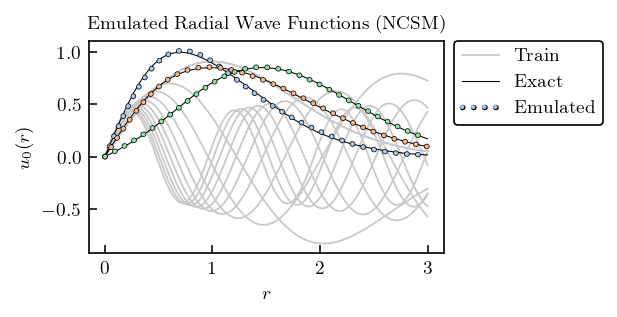

In [13]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(r_grid, osc_wfs[:, 0], label='Train', **BASIS_KWARGS)
ax.plot(r_grid, osc_wfs, **BASIS_KWARGS)
for i in range(3):
    if i == 0:
        label_full = 'Exact'
        label_pred = 'Emulated'
    else:
        label_full = label_pred = None
    ax.plot(r_grid, osc_wfs @ ham_ncsm.exact_wave_function(p_valid[i]), label=label_full, **FULL_KWARGS)
    ax.plot(r_grid, osc_wfs @ ham_ncsm.emulate_wave_function(p_valid[i]), label=label_pred, **PRED_KWARGS)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$u_0(r)$")
ax.set_title("Emulated Radial Wave Functions (NCSM)")
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
fig.savefig("perturbed_oscillator_ncsm.png")

How wrong were we?

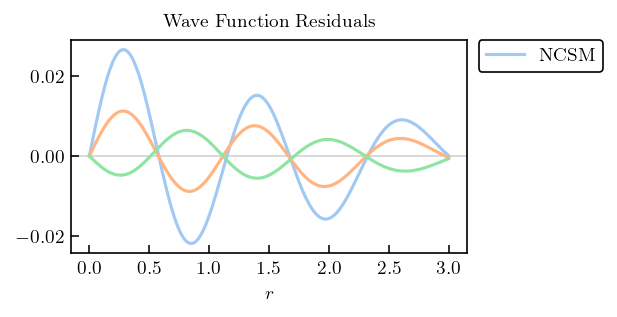

In [14]:
fig, ax = plt.subplots(figsize=(4, 2))
for i in range(3):
#     ax.plot(
#         r_grid,
#         osc_wfs @ (ham.exact_wave_function(p_valid[i])-ham.emulate_wave_function(p_valid[i])),
#         ls='-', label='Efficient' if i == 0 else None
#     )
    ax.plot(
        r_grid,
        osc_wfs @ (ham_ncsm.exact_wave_function(p_valid[i])-ham_ncsm.emulate_wave_function(p_valid[i])),
        ls='-', label='NCSM' if i == 0 else None
    )
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_xlabel(r"$r$")
ax.set_title("Wave Function Residuals")
ax.axhline(0, 0, 1, c='lightgrey', lw=0.8, zorder=0)
fig.savefig("perturbed_oscillator_ground_state_wave_function_residuals_no_ec.png")

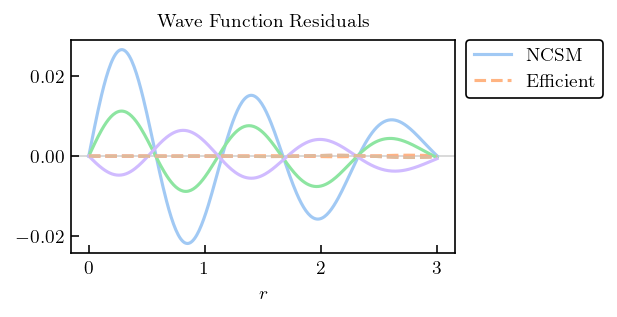

In [15]:
fig, ax = plt.subplots(figsize=(4, 2))
for i in range(3):
    ax.plot(
        r_grid,
        osc_wfs @ (ham_ncsm.exact_wave_function(p_valid[i])-ham_ncsm.emulate_wave_function(p_valid[i])),
        ls='-', label='NCSM' if i == 0 else None
    )
    ax.plot(
        r_grid,
        osc_wfs @ (ham.exact_wave_function(p_valid[i])-ham.emulate_wave_function(p_valid[i])),
        ls='--', label='Efficient' if i == 0 else None
    )
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_xlabel(r"$r$")
ax.set_title("Wave Function Residuals")
ax.axhline(0, 0, 1, c='lightgrey', lw=0.8, zorder=0)
fig.savefig("perturbed_oscillator_ground_state_wave_function_residuals.png")

The above charts are pretty convincing that the efficient emulator is better. Let's see it on a log plot too.

Text(0.5, 1.0, 'Wave Function Absolute Residuals')

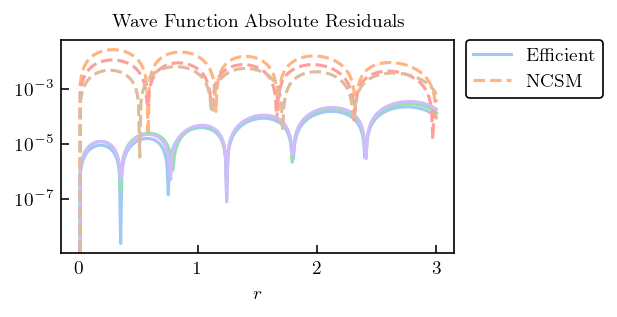

In [16]:
fig, ax = plt.subplots(figsize=(4, 2))
for i in range(3):
    ax.semilogy(
        r_grid,
        np.abs(osc_wfs @ (ham.exact_wave_function(p_valid[i])-ham.emulate_wave_function(p_valid[i]))),
        ls='-', label='Efficient' if i == 0 else None
    )
    ax.semilogy(
        r_grid,
        np.abs(osc_wfs @ (ham_ncsm.exact_wave_function(p_valid[i])-ham_ncsm.emulate_wave_function(p_valid[i]))),
        ls='--', label='NCSM' if i == 0 else None
    )
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_xlabel(r"$r$")
ax.set_title("Wave Function Absolute Residuals")

Let's also compare to a GP trained on the energies.

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [18]:
kernel = C(1) * RBF(length_scale=[1,1,1])
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(p_train, ham.E_train)
E_pred_gp, E_std_gp = gp.predict(p_valid, return_std=True)

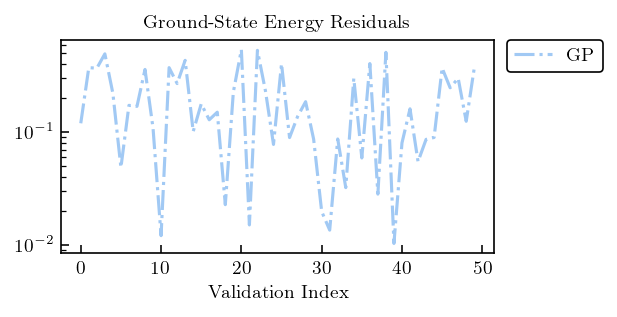

In [19]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.semilogy(np.arange(len(E_full)), np.abs(E_pred_gp-E_full), label='GP', ls='-.')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_title("Ground-State Energy Residuals")
ax.set_xlabel("Validation Index")
fig.savefig("perturbed_oscillator_ground_state_energy_residuals_gp_only.png")

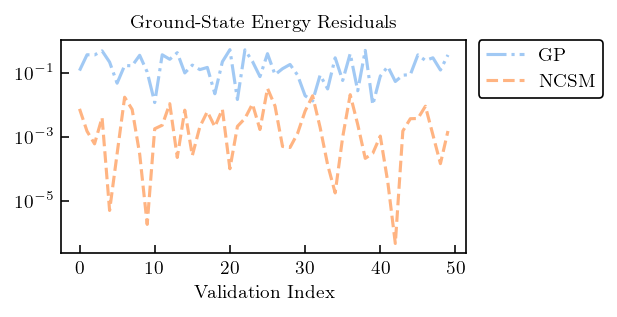

In [20]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.semilogy(np.arange(len(E_full)), np.abs(E_pred_gp-E_full), label='GP', ls='-.')
ax.semilogy((E_pred_ncsm-E_full), label='NCSM', ls='--')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_title("Ground-State Energy Residuals")
ax.set_xlabel("Validation Index")
fig.savefig("perturbed_oscillator_ground_state_energy_residuals_no_ec.png")

## Uncertainty Quantification

In [21]:
n_valid_1d = 100
p0_valid_1d = np.linspace(-1, 1, n_valid_1d)
p_valid_1d = np.stack([p0_valid_1d, 4.5*np.ones(n_valid_1d), -3.55 * np.ones(n_valid_1d)], axis=-1)
p_valid_1d.shape

(100, 3)

In [22]:
E_valid_1d_true = np.array([ham.predict(p, use_emulator=False) for p in p_valid_1d])
E_valid_1d_pred = np.array([ham.predict(p, use_emulator=True) for p in p_valid_1d])

psi_valid_1d_true = np.array([ham.exact_wave_function(p) for p in p_valid_1d])
psi_valid_1d_pred = np.array([ham.emulate_wave_function(p) for p in p_valid_1d])

abs_residual_1d = np.abs(E_valid_1d_pred - E_valid_1d_true)
psi_residual_1d = np.linalg.norm(psi_valid_1d_pred - psi_valid_1d_true, axis=-1)
stdv_psi_valid_1d = np.sqrt(np.array([ham.variance_expensive(p) for p in p_valid_1d]))
stdv_E_valid_1d = stdv_psi_valid_1d ** 2

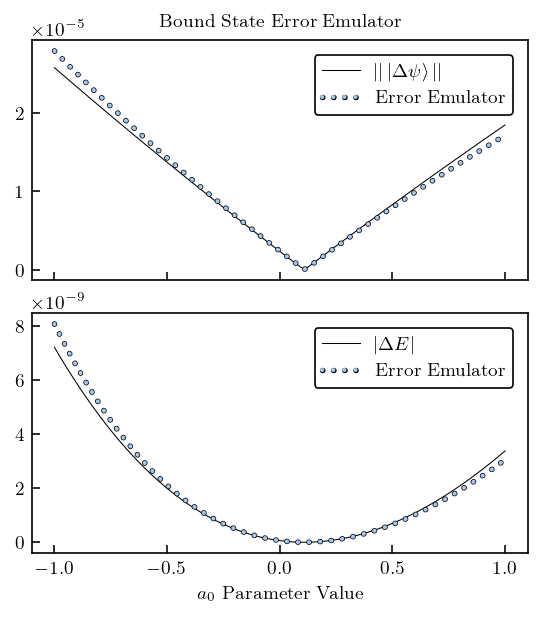

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(3.5, 4), sharex=True)

ax = axes[0]
ax.plot(p0_valid_1d, psi_residual_1d, label=r"$||\,|{\Delta\psi}\rangle\,||$", **FULL_KWARGS)
ax.plot(p0_valid_1d, stdv_psi_valid_1d * np.average(psi_residual_1d/stdv_psi_valid_1d), label="Error Emulator", **PRED_KWARGS)
ax.legend()
ax.set_title("Bound State Error Emulator")

ax = axes[1]
ax.plot(p0_valid_1d, abs_residual_1d, label=r"$|\Delta E|$", **FULL_KWARGS)
ax.plot(p0_valid_1d, stdv_E_valid_1d * np.average(abs_residual_1d/stdv_E_valid_1d), label="Error Emulator", **PRED_KWARGS)
ax.set_xlabel("$a_0$ Parameter Value")
ax.legend()
fig.savefig("bound_state_error_emulator.png")

# Operators

Everything above has used the Hamiltonian, since we're looking at energies and wave functions.
But there is also an operator class that takes the trained `BoundStateHamiltonian` object and an operator as given.
It can then predict the expectation value exactly or emulate it.

In [24]:
op = BoundStateOperator(name='R', ham=ham, op0=R)
op_ncsm = BoundStateOperator(name='R (NCSM)', ham=ham_ncsm, op0=R)

In [25]:
op

<Osc w/Gaussian Perturbation | R | Osc w/Gaussian Perturbation>

It has similar methods as the Hamiltonian object. `predict` returns the expectation value of the operator.

In [26]:
R_full = np.stack([op.predict(p_i, use_emulator=False) for p_i in p_valid])
R_pred = np.stack([op.predict(p_i, use_emulator=True) for p_i in p_valid])

R_pred_ncsm = np.stack([op_ncsm.predict(p_i, use_emulator=True) for p_i in p_valid])

Train a GP on the radius at the same training points as the other emulators.

In [27]:
kernel = C(1) * RBF(length_scale=[1,1,1])
gp_op = GaussianProcessRegressor(kernel=kernel)
gp_op.fit(p_train, np.stack([op.predict(p_i, use_emulator=False) for p_i in p_train]))
R_pred_gp, R_std_gp = gp_op.predict(p_valid, return_std=True)

Check it out!

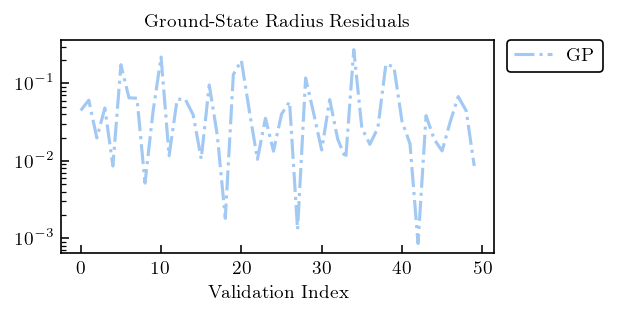

In [28]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.semilogy(np.arange(len(R_full)), np.abs(R_pred_gp-R_full), label='GP', ls='-.')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_title("Ground-State Radius Residuals")
ax.set_xlabel("Validation Index")
fig.savefig("perturbed_oscillator_ground_state_radius_residuals_gp_only.png")

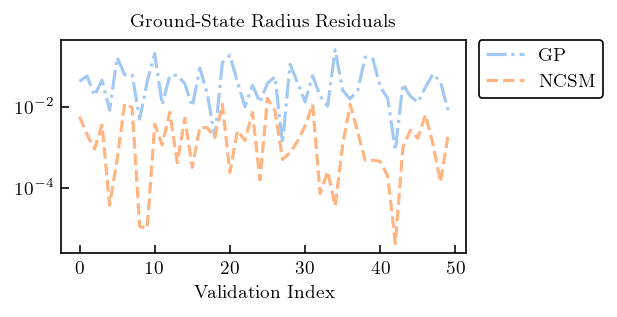

In [29]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.semilogy(np.arange(len(R_full)), np.abs(R_pred_gp-R_full), label='GP', ls='-.')
ax.semilogy(np.abs(R_pred_ncsm-R_full), label='NCSM', ls='--')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_title("Ground-State Radius Residuals")
ax.set_xlabel("Validation Index")
fig.savefig("perturbed_oscillator_ground_state_radius_residuals_no_ec.png")

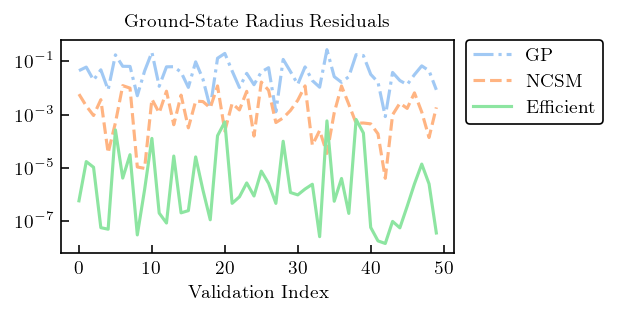

In [30]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.semilogy(np.arange(len(R_full)), np.abs(R_pred_gp-R_full), label='GP', ls='-.')
ax.semilogy(np.abs(R_pred_ncsm-R_full), label='NCSM', ls='--')
ax.semilogy(np.abs(R_pred-R_full), label='Efficient')
ax.legend(loc='upper left', bbox_to_anchor=(1.03,1), borderaxespad=0)
ax.set_title("Ground-State Radius Residuals")
ax.set_xlabel("Validation Index")
fig.savefig("perturbed_oscillator_ground_state_radius_residuals.png")